In [23]:
import numpy as np
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
from utils import Logger

In [5]:
# Load dataset

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [27]:
# create dataloaders
def train_loader(batch_size):
    return DataLoader(train_data, batch_size=batch_size, shuffle=True)


def test_loader(batch_size):
    return DataLoader(test_data, batch_size=batch_size, shuffle=False)


data_loader = train_loader(64)
num_batches = len(data_loader)

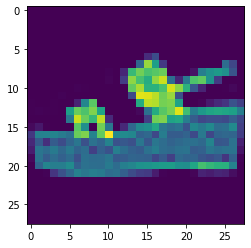

In [7]:
plt.imshow(train_data[12][0].reshape(28,28))

In [8]:
# Discriminator
# goal to recognize if data is "real" -> image belongs to real dataset
# or "fake" -> belongs to generated data
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 28*28
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


discriminator = DiscriminatorNet()

In [48]:
def images_to_vectors(images):
    return images.view(images.size(0),784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [10]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [11]:
def noise(size):
    return Variable(torch.randn(size,100))

In [12]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [13]:
loss = nn.BCELoss()

In [14]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [15]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [16]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)    # Reset gradients
    optimizer.zero_grad()    # Sample noise and generate fake data
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error

In [49]:
num_test_samples = 16
test_noise = noise(num_test_samples)
x = generator(test_noise)
x_ = vectors_to_images(generator(test_noise))
x_.shape


#plt.imshow(x[0].reshape(28,28).detach().numpy())

torch.Size([16, 1, 28, 28])

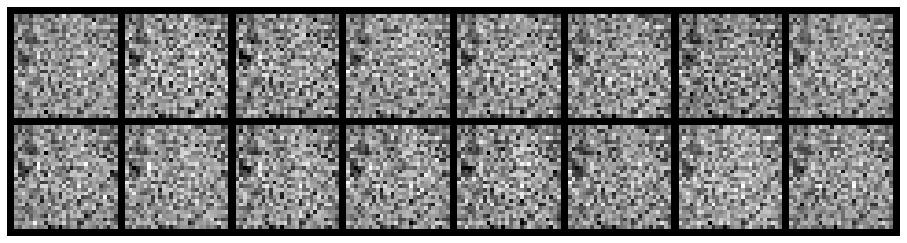

Epoch: [0/200], Batch Num: [0/938]
Discriminator Loss: 1.1100, Generator Loss: 0.5841
D(x): 0.7443, D(G(z)): 0.5541


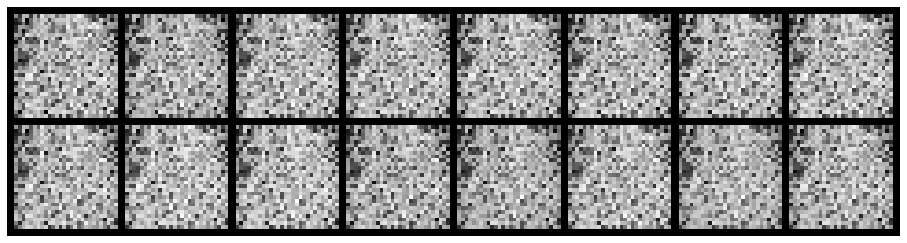

Epoch: [0/200], Batch Num: [100/938]
Discriminator Loss: 0.5930, Generator Loss: 2.3611
D(x): 0.6604, D(G(z)): 0.1489


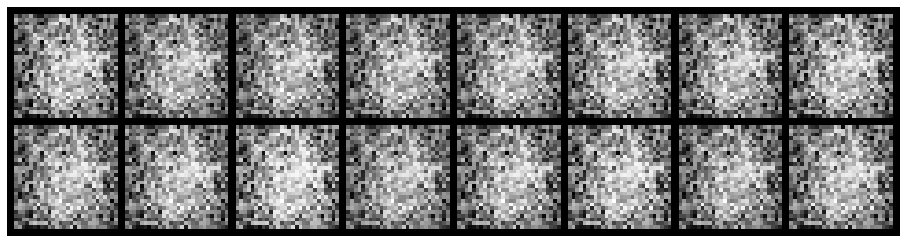

Epoch: [0/200], Batch Num: [200/938]
Discriminator Loss: 1.3266, Generator Loss: 0.8952
D(x): 0.5195, D(G(z)): 0.4843


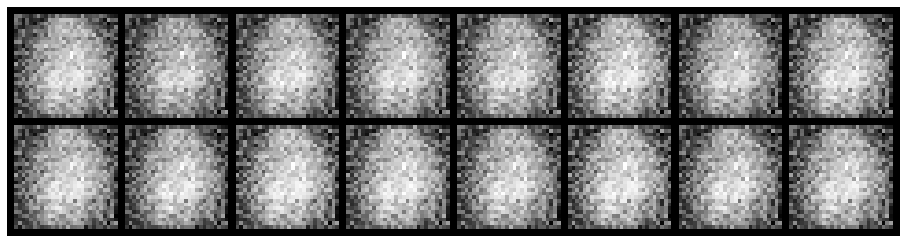

Epoch: [0/200], Batch Num: [300/938]
Discriminator Loss: 2.0995, Generator Loss: 0.3071
D(x): 0.4899, D(G(z)): 0.7363


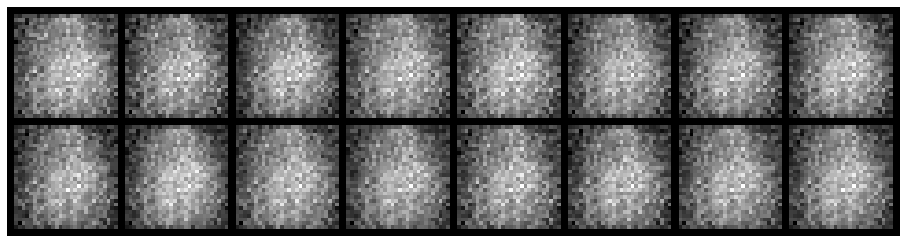

Epoch: [0/200], Batch Num: [400/938]
Discriminator Loss: 1.1241, Generator Loss: 0.6764
D(x): 0.7431, D(G(z)): 0.5579


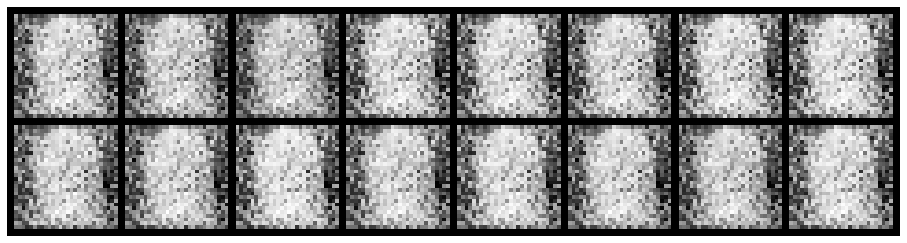

Epoch: [0/200], Batch Num: [500/938]
Discriminator Loss: 0.6963, Generator Loss: 3.1627
D(x): 0.7248, D(G(z)): 0.2629


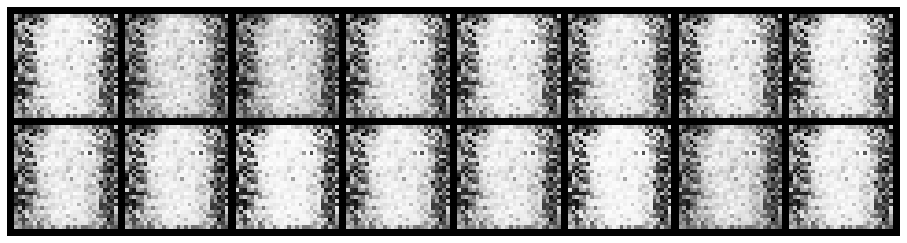

Epoch: [0/200], Batch Num: [600/938]
Discriminator Loss: 0.4196, Generator Loss: 2.9346
D(x): 0.8137, D(G(z)): 0.1778


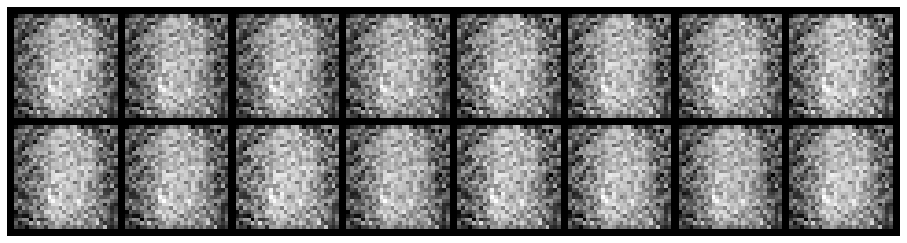

Epoch: [0/200], Batch Num: [700/938]
Discriminator Loss: 1.2043, Generator Loss: 0.8501
D(x): 0.6290, D(G(z)): 0.4837


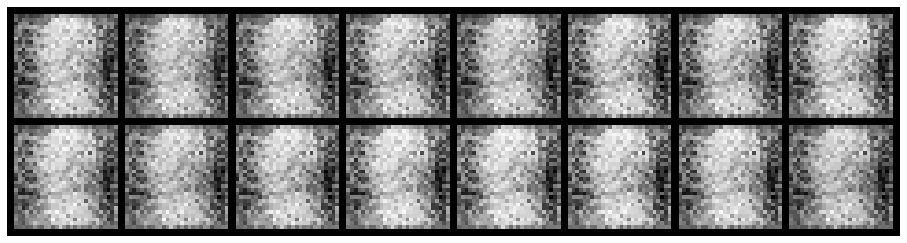

Epoch: [0/200], Batch Num: [800/938]
Discriminator Loss: 1.2183, Generator Loss: 1.7053
D(x): 0.4531, D(G(z)): 0.2505


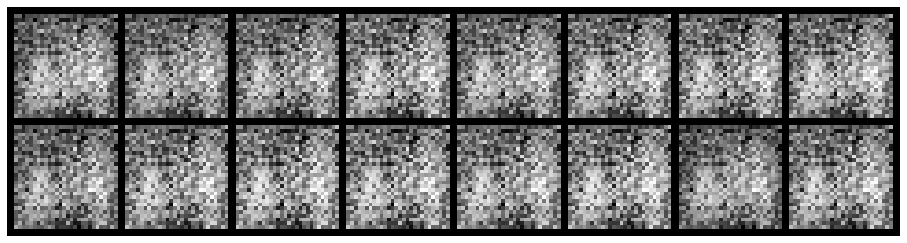

Epoch: [0/200], Batch Num: [900/938]
Discriminator Loss: 1.2482, Generator Loss: 1.0891
D(x): 0.7982, D(G(z)): 0.5691


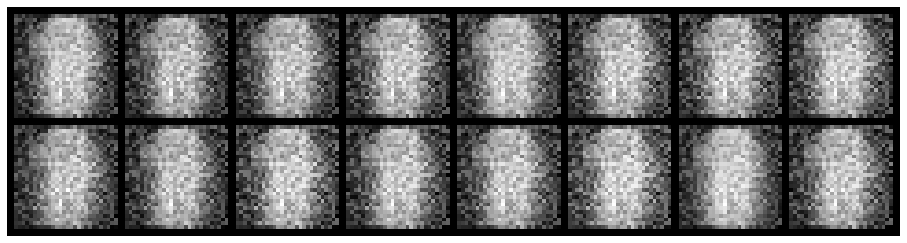

Epoch: [1/200], Batch Num: [0/938]
Discriminator Loss: 2.5676, Generator Loss: 1.5086
D(x): 0.4819, D(G(z)): 0.4874


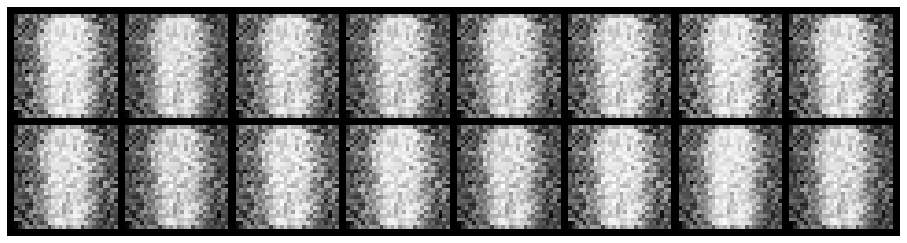

Epoch: [1/200], Batch Num: [100/938]
Discriminator Loss: 0.8845, Generator Loss: 1.2624
D(x): 0.7336, D(G(z)): 0.3377


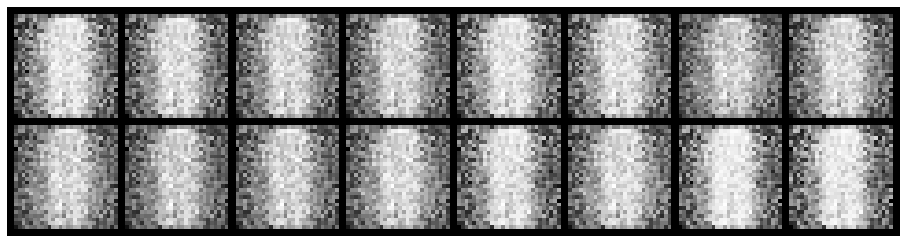

Epoch: [1/200], Batch Num: [200/938]
Discriminator Loss: 0.9292, Generator Loss: 1.2976
D(x): 0.7064, D(G(z)): 0.3590


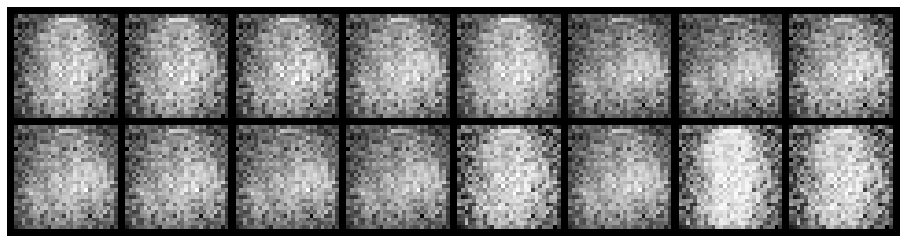

Epoch: [1/200], Batch Num: [300/938]
Discriminator Loss: 0.8508, Generator Loss: 1.4985
D(x): 0.6657, D(G(z)): 0.2585


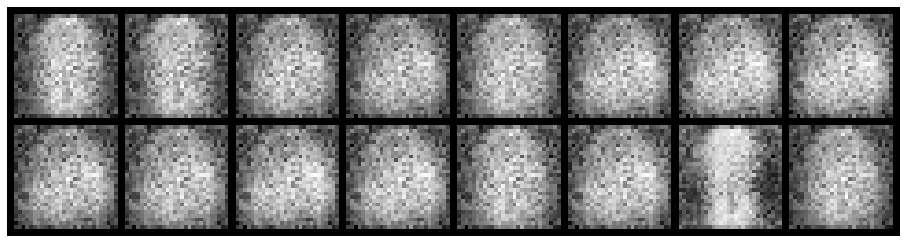

Epoch: [1/200], Batch Num: [400/938]
Discriminator Loss: 1.4433, Generator Loss: 1.2729
D(x): 0.5995, D(G(z)): 0.4517


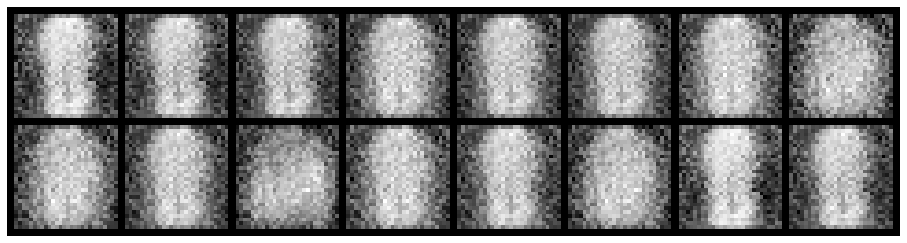

Epoch: [1/200], Batch Num: [500/938]
Discriminator Loss: 0.5309, Generator Loss: 2.1101
D(x): 0.8532, D(G(z)): 0.2462


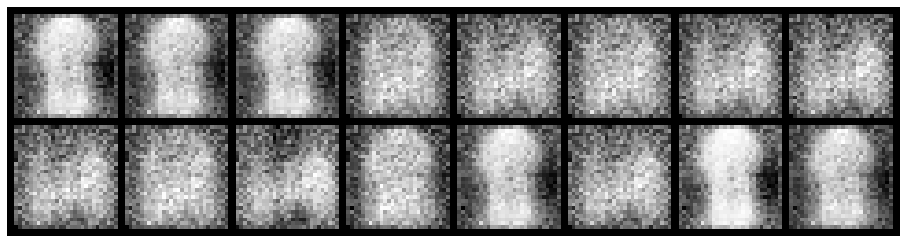

Epoch: [1/200], Batch Num: [600/938]
Discriminator Loss: 0.8521, Generator Loss: 1.7716
D(x): 0.8033, D(G(z)): 0.3307


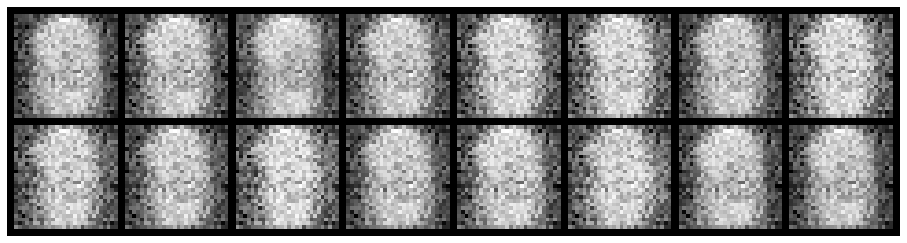

Epoch: [1/200], Batch Num: [700/938]
Discriminator Loss: 0.6763, Generator Loss: 2.1773
D(x): 0.8107, D(G(z)): 0.2432


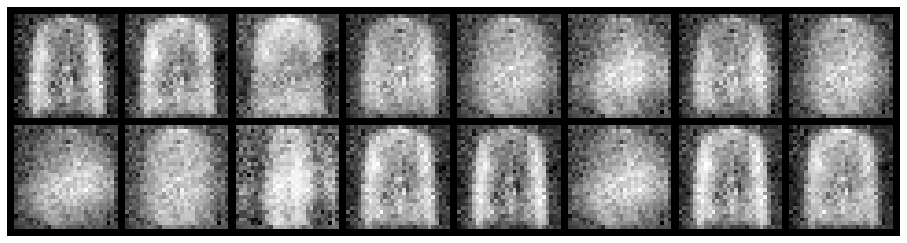

Epoch: [1/200], Batch Num: [800/938]
Discriminator Loss: 1.4360, Generator Loss: 1.5151
D(x): 0.5610, D(G(z)): 0.3387


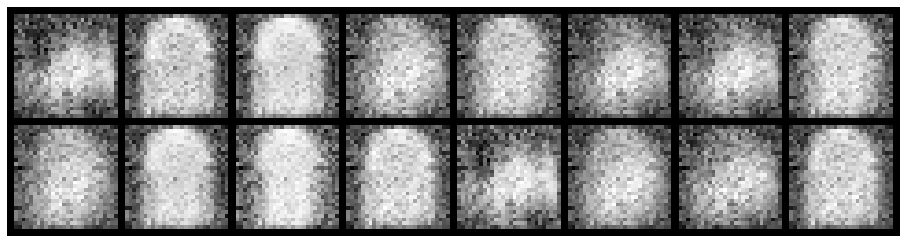

Epoch: [1/200], Batch Num: [900/938]
Discriminator Loss: 0.9808, Generator Loss: 1.5022
D(x): 0.6359, D(G(z)): 0.3274


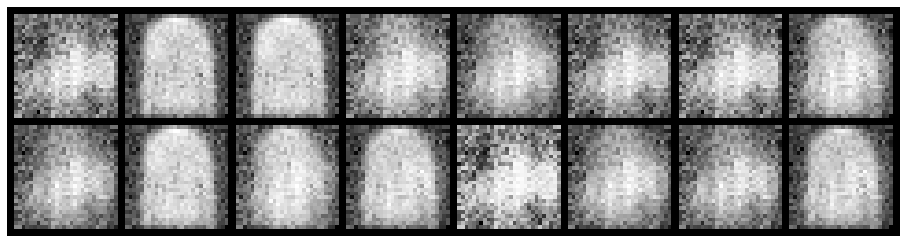

Epoch: [2/200], Batch Num: [0/938]
Discriminator Loss: 0.9973, Generator Loss: 1.5690
D(x): 0.6720, D(G(z)): 0.3670


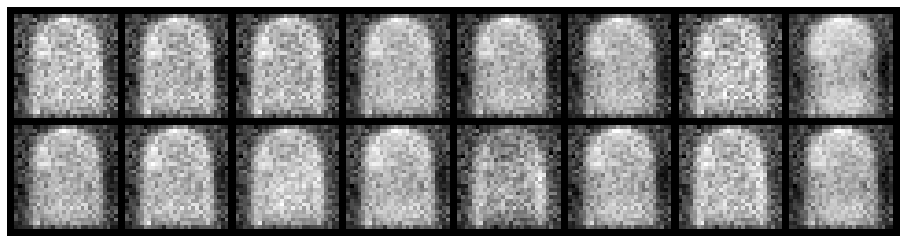

Epoch: [2/200], Batch Num: [100/938]
Discriminator Loss: 0.4648, Generator Loss: 1.7113
D(x): 0.8921, D(G(z)): 0.2209


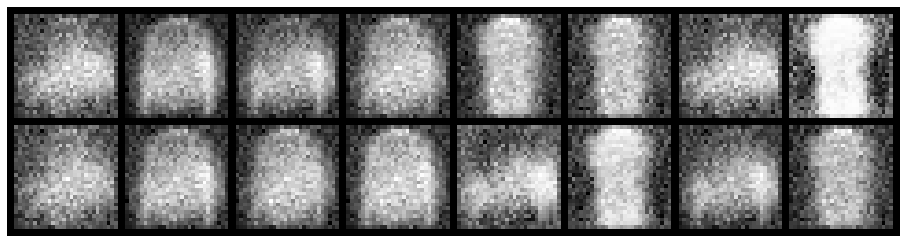

Epoch: [2/200], Batch Num: [200/938]
Discriminator Loss: 0.9643, Generator Loss: 1.1017
D(x): 0.6917, D(G(z)): 0.4020


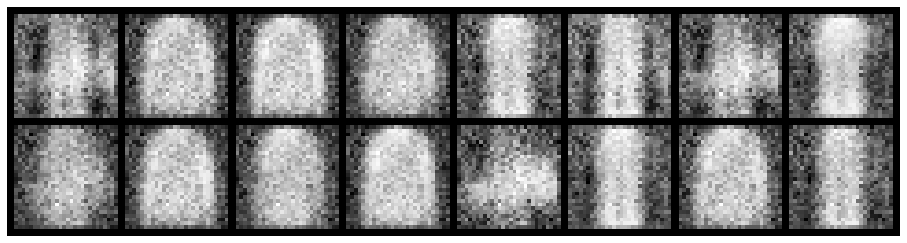

Epoch: [2/200], Batch Num: [300/938]
Discriminator Loss: 1.1433, Generator Loss: 1.9333
D(x): 0.5417, D(G(z)): 0.2790


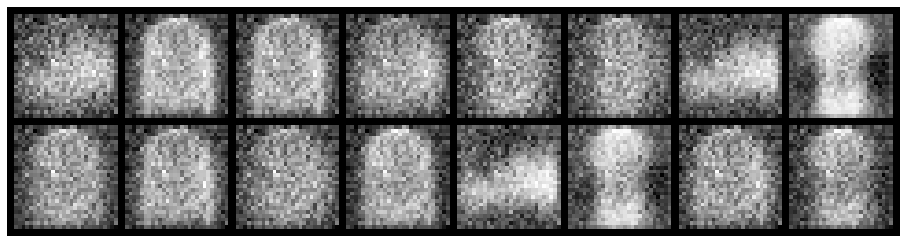

Epoch: [2/200], Batch Num: [400/938]
Discriminator Loss: 1.2262, Generator Loss: 1.0457
D(x): 0.6285, D(G(z)): 0.4568


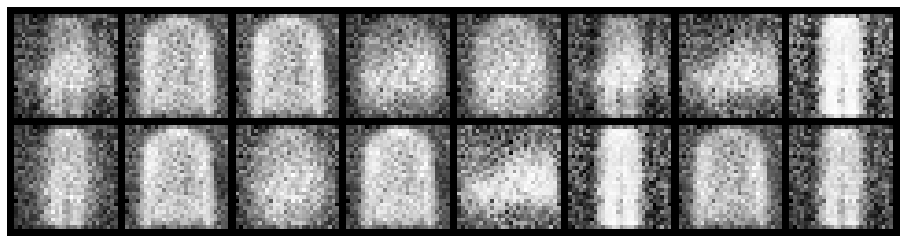

Epoch: [2/200], Batch Num: [500/938]
Discriminator Loss: 0.6925, Generator Loss: 2.1108
D(x): 0.7506, D(G(z)): 0.2447


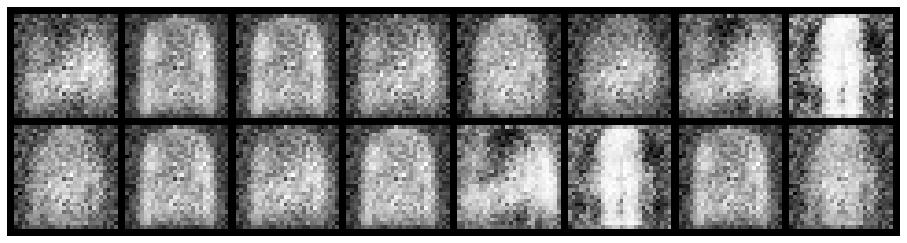

Epoch: [2/200], Batch Num: [600/938]
Discriminator Loss: 0.7291, Generator Loss: 1.4135
D(x): 0.7437, D(G(z)): 0.3005


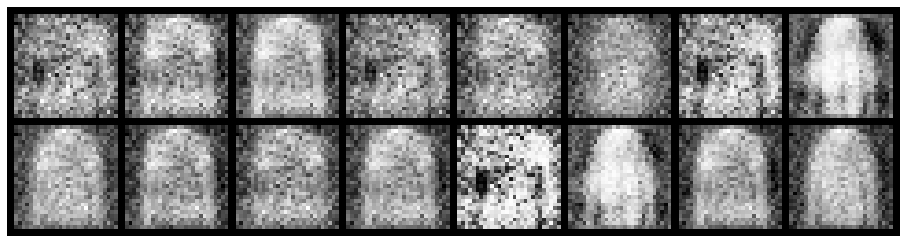

Epoch: [2/200], Batch Num: [700/938]
Discriminator Loss: 0.8061, Generator Loss: 1.2246
D(x): 0.8351, D(G(z)): 0.4160


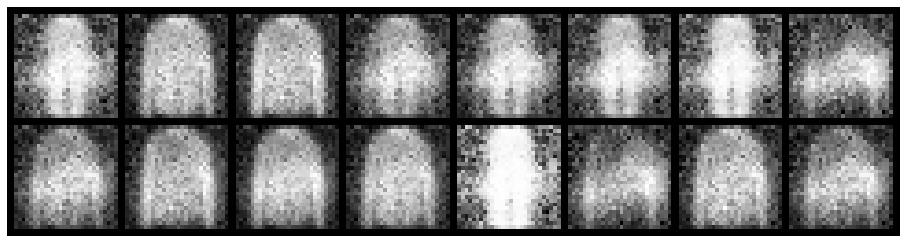

Epoch: [2/200], Batch Num: [800/938]
Discriminator Loss: 1.4202, Generator Loss: 1.1852
D(x): 0.5148, D(G(z)): 0.4182


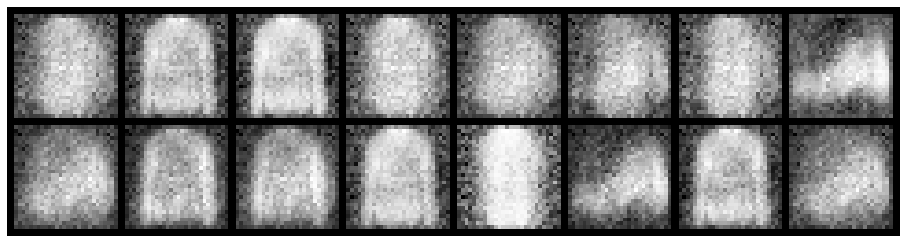

Epoch: [2/200], Batch Num: [900/938]
Discriminator Loss: 1.3424, Generator Loss: 1.3703
D(x): 0.5190, D(G(z)): 0.3129


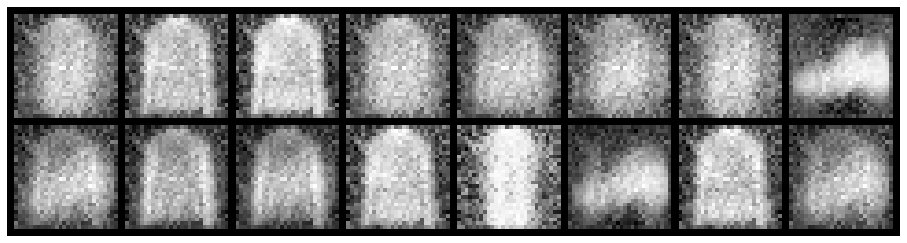

Epoch: [3/200], Batch Num: [0/938]
Discriminator Loss: 0.7839, Generator Loss: 1.4676
D(x): 0.7321, D(G(z)): 0.3000


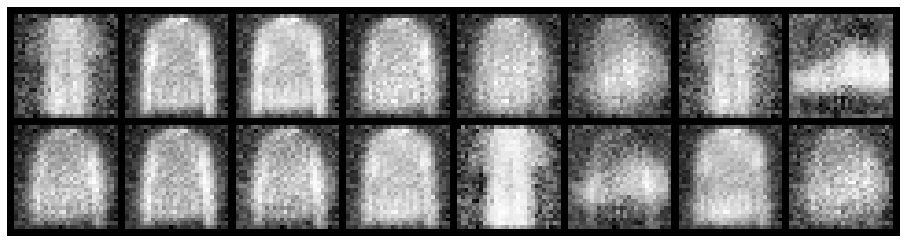

Epoch: [3/200], Batch Num: [100/938]
Discriminator Loss: 1.1415, Generator Loss: 1.2870
D(x): 0.6510, D(G(z)): 0.3739


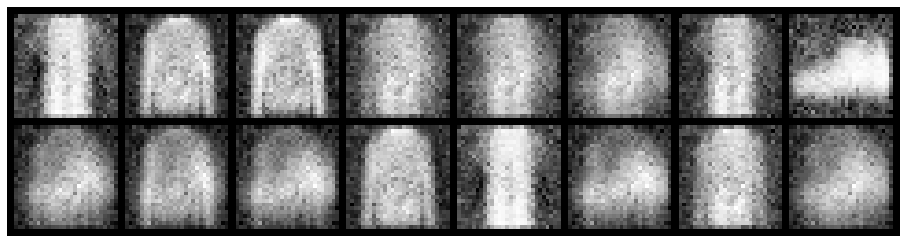

Epoch: [3/200], Batch Num: [200/938]
Discriminator Loss: 0.8766, Generator Loss: 1.5658
D(x): 0.6621, D(G(z)): 0.2659


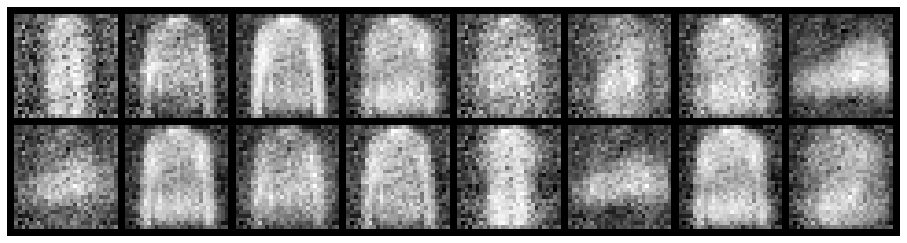

Epoch: [3/200], Batch Num: [300/938]
Discriminator Loss: 1.3525, Generator Loss: 1.8245
D(x): 0.6670, D(G(z)): 0.4072


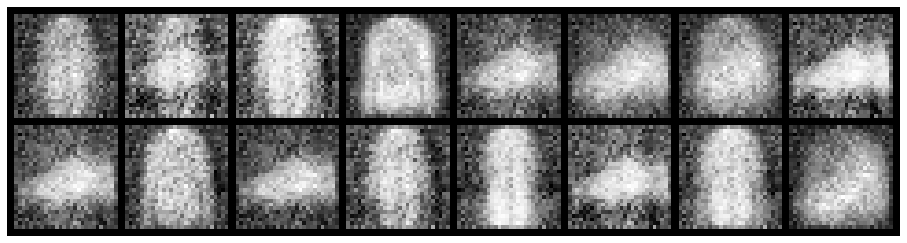

Epoch: [3/200], Batch Num: [400/938]
Discriminator Loss: 0.8737, Generator Loss: 1.7026
D(x): 0.7026, D(G(z)): 0.3153


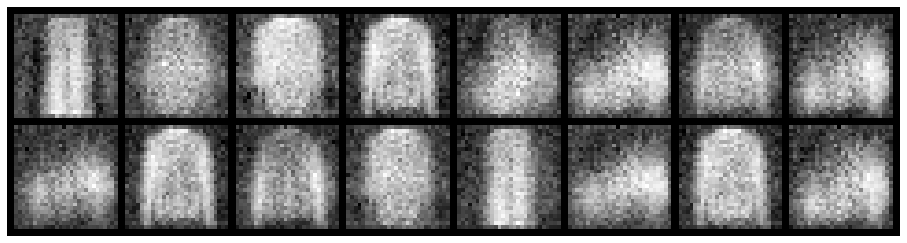

Epoch: [3/200], Batch Num: [500/938]
Discriminator Loss: 1.0168, Generator Loss: 1.6899
D(x): 0.6935, D(G(z)): 0.2953


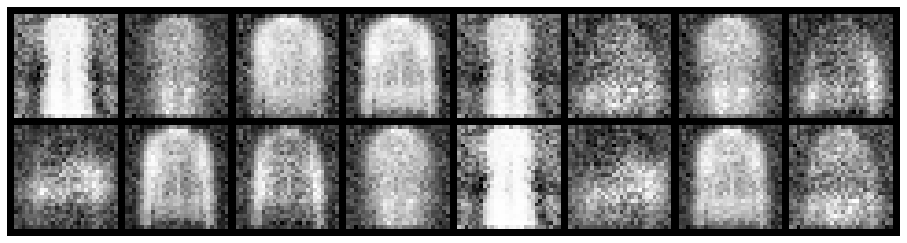

Epoch: [3/200], Batch Num: [600/938]
Discriminator Loss: 1.0393, Generator Loss: 1.3145
D(x): 0.7143, D(G(z)): 0.3814


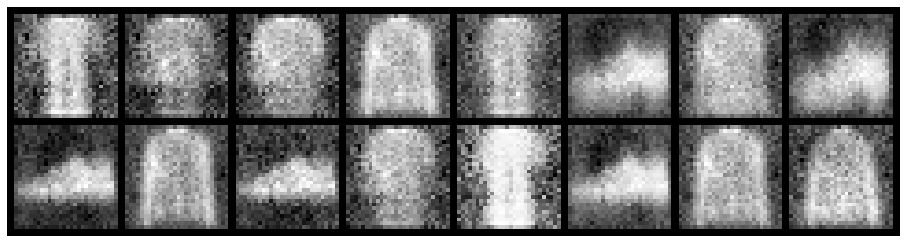

Epoch: [3/200], Batch Num: [700/938]
Discriminator Loss: 1.2748, Generator Loss: 1.0870
D(x): 0.5924, D(G(z)): 0.3884


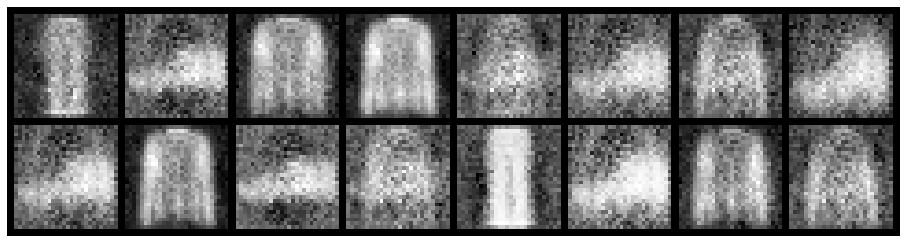

Epoch: [3/200], Batch Num: [800/938]
Discriminator Loss: 0.8983, Generator Loss: 1.7017
D(x): 0.6982, D(G(z)): 0.3004


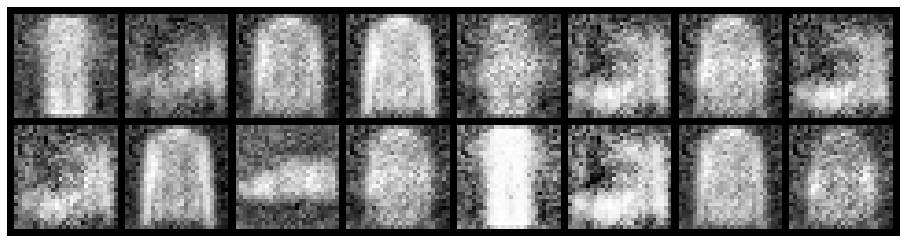

Epoch: [3/200], Batch Num: [900/938]
Discriminator Loss: 0.9609, Generator Loss: 1.4879
D(x): 0.6529, D(G(z)): 0.3043


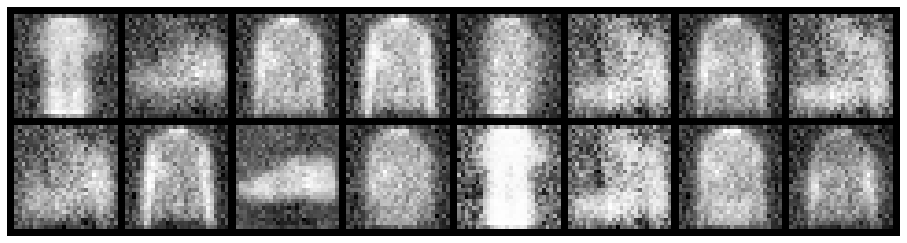

Epoch: [4/200], Batch Num: [0/938]
Discriminator Loss: 1.0875, Generator Loss: 1.7978
D(x): 0.6380, D(G(z)): 0.3636


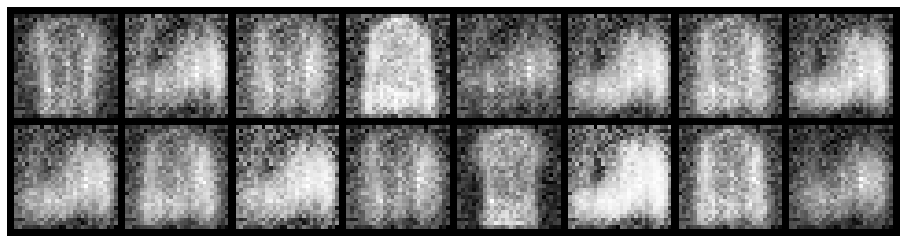

Epoch: [4/200], Batch Num: [100/938]
Discriminator Loss: 0.8842, Generator Loss: 1.4204
D(x): 0.7506, D(G(z)): 0.3489


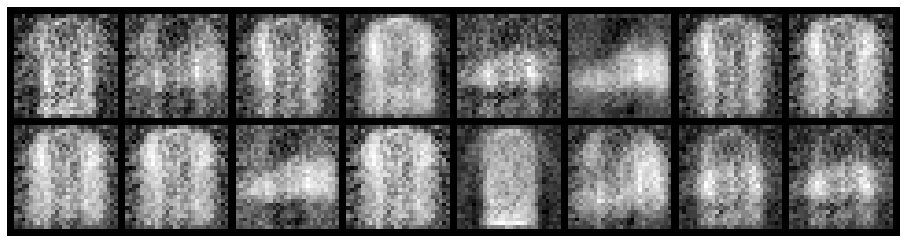

Epoch: [4/200], Batch Num: [200/938]
Discriminator Loss: 0.9933, Generator Loss: 1.3407
D(x): 0.7347, D(G(z)): 0.3657


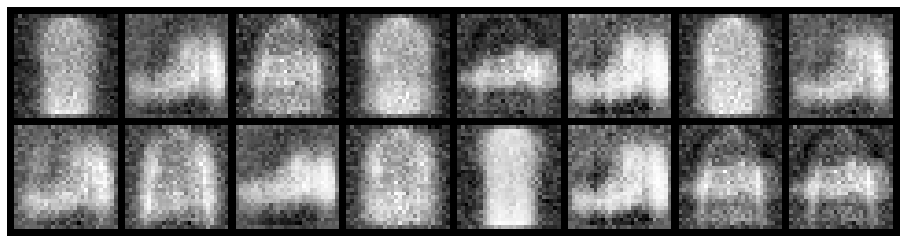

Epoch: [4/200], Batch Num: [300/938]
Discriminator Loss: 0.7033, Generator Loss: 1.8225
D(x): 0.7097, D(G(z)): 0.2011


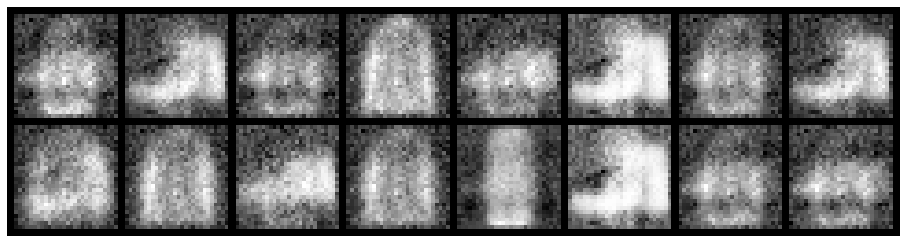

Epoch: [4/200], Batch Num: [400/938]
Discriminator Loss: 0.9340, Generator Loss: 1.6090
D(x): 0.6556, D(G(z)): 0.2802


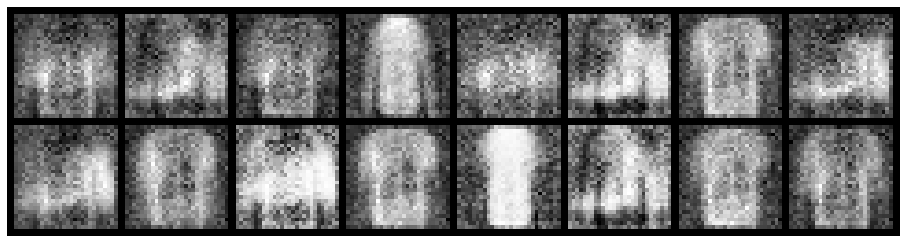

Epoch: [4/200], Batch Num: [500/938]
Discriminator Loss: 0.7631, Generator Loss: 1.7570
D(x): 0.7777, D(G(z)): 0.2953


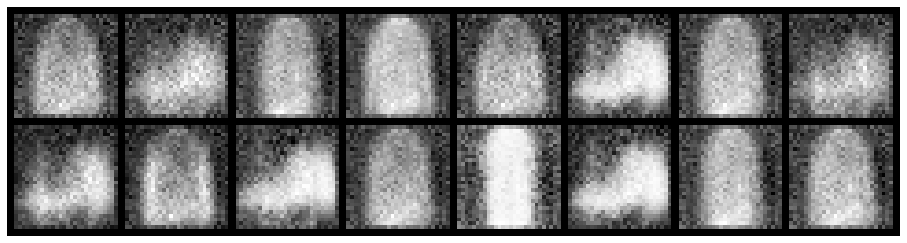

Epoch: [4/200], Batch Num: [600/938]
Discriminator Loss: 0.8219, Generator Loss: 1.7650
D(x): 0.6543, D(G(z)): 0.2136


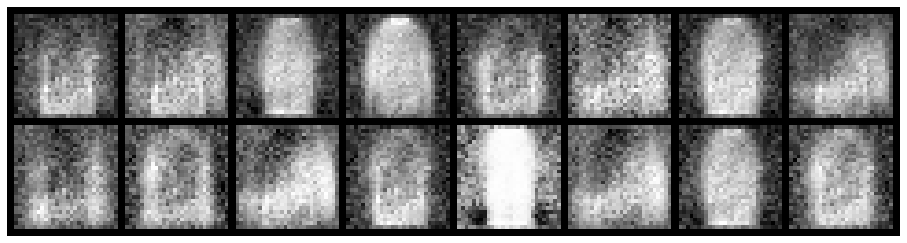

Epoch: [4/200], Batch Num: [700/938]
Discriminator Loss: 1.2928, Generator Loss: 1.0483
D(x): 0.6370, D(G(z)): 0.4281


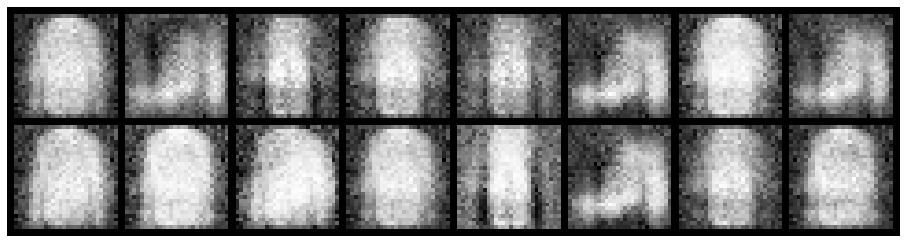

Epoch: [4/200], Batch Num: [800/938]
Discriminator Loss: 0.8345, Generator Loss: 2.5039
D(x): 0.6827, D(G(z)): 0.1777


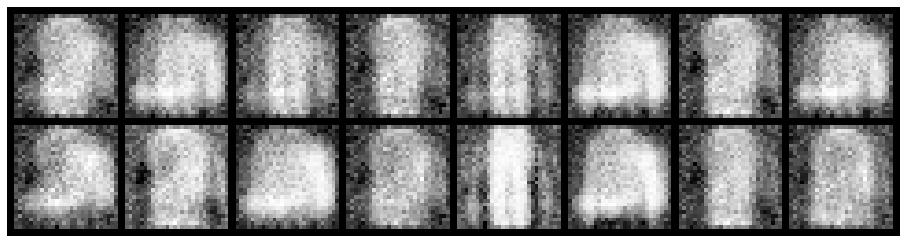

Epoch: [4/200], Batch Num: [900/938]
Discriminator Loss: 0.8981, Generator Loss: 1.4152
D(x): 0.7236, D(G(z)): 0.3186


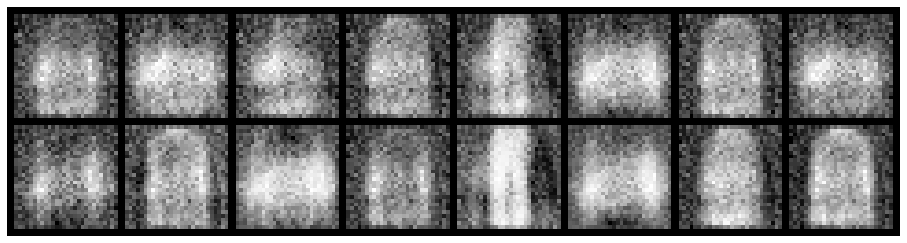

Epoch: [5/200], Batch Num: [0/938]
Discriminator Loss: 0.6199, Generator Loss: 1.7537
D(x): 0.7561, D(G(z)): 0.2072


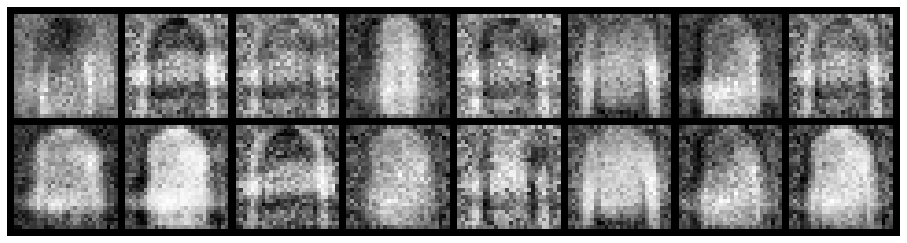

Epoch: [5/200], Batch Num: [100/938]
Discriminator Loss: 1.3540, Generator Loss: 1.7902
D(x): 0.7712, D(G(z)): 0.3992


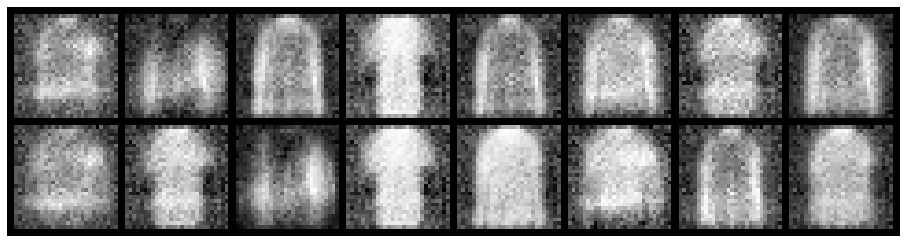

Epoch: [5/200], Batch Num: [200/938]
Discriminator Loss: 1.0464, Generator Loss: 1.2294
D(x): 0.6360, D(G(z)): 0.3230


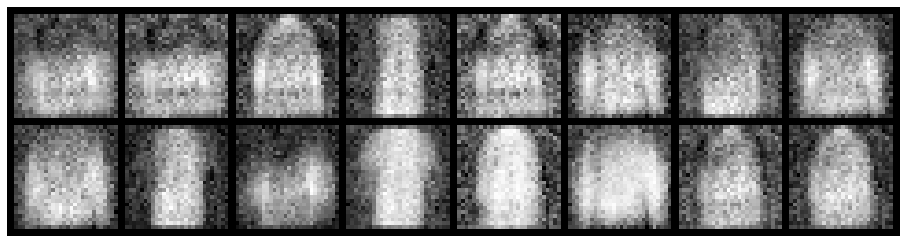

Epoch: [5/200], Batch Num: [300/938]
Discriminator Loss: 0.7738, Generator Loss: 1.4225
D(x): 0.7702, D(G(z)): 0.3228


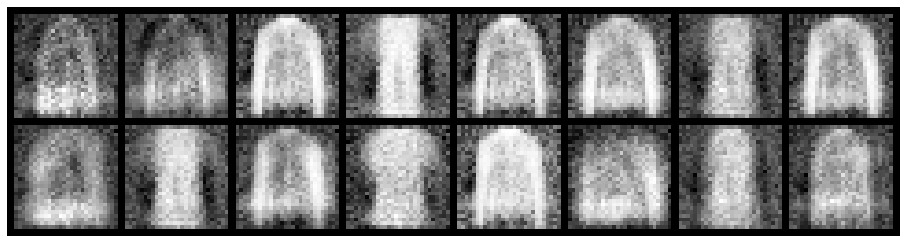

Epoch: [5/200], Batch Num: [400/938]
Discriminator Loss: 0.8383, Generator Loss: 1.3639
D(x): 0.7415, D(G(z)): 0.3001


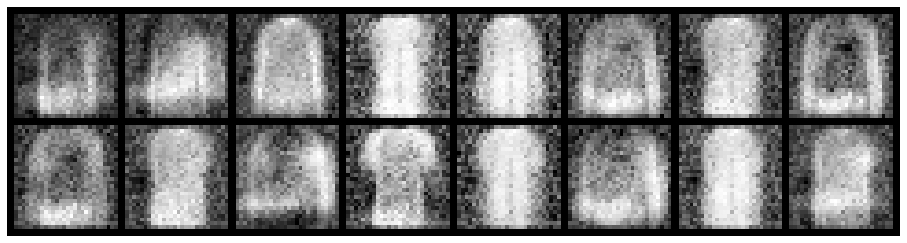

Epoch: [5/200], Batch Num: [500/938]
Discriminator Loss: 0.9521, Generator Loss: 1.5639
D(x): 0.6299, D(G(z)): 0.2722


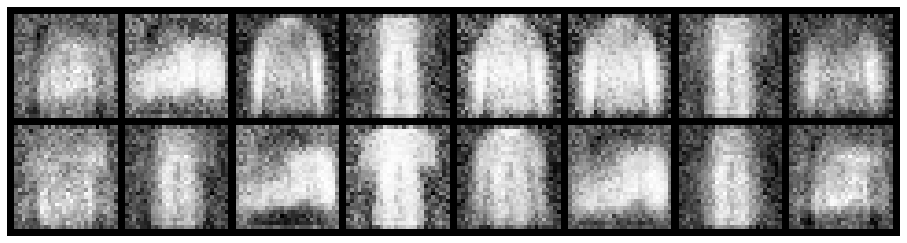

Epoch: [5/200], Batch Num: [600/938]
Discriminator Loss: 0.7847, Generator Loss: 1.4235
D(x): 0.6994, D(G(z)): 0.2731


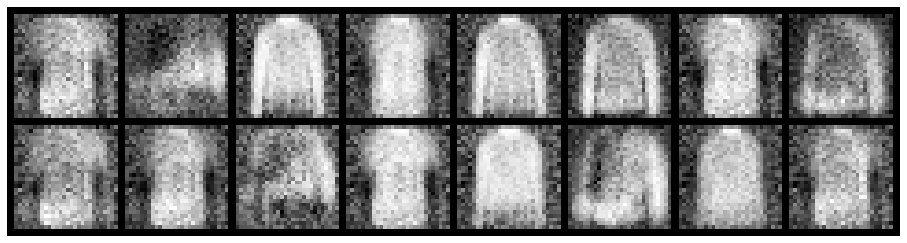

Epoch: [5/200], Batch Num: [700/938]
Discriminator Loss: 1.1637, Generator Loss: 1.3865
D(x): 0.6236, D(G(z)): 0.3393


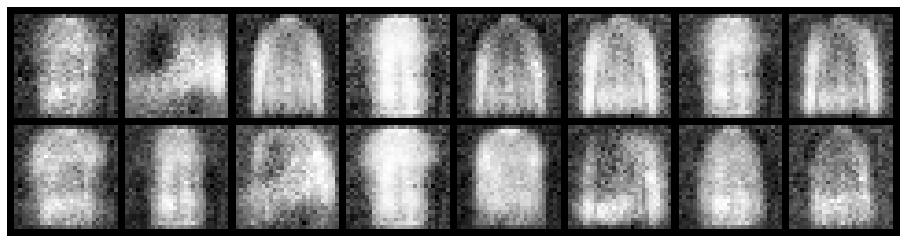

Epoch: [5/200], Batch Num: [800/938]
Discriminator Loss: 1.5471, Generator Loss: 1.3009
D(x): 0.5616, D(G(z)): 0.3423


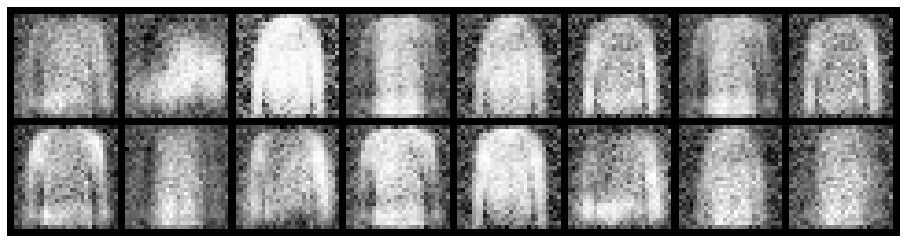

Epoch: [5/200], Batch Num: [900/938]
Discriminator Loss: 1.0576, Generator Loss: 1.4472
D(x): 0.6529, D(G(z)): 0.2793


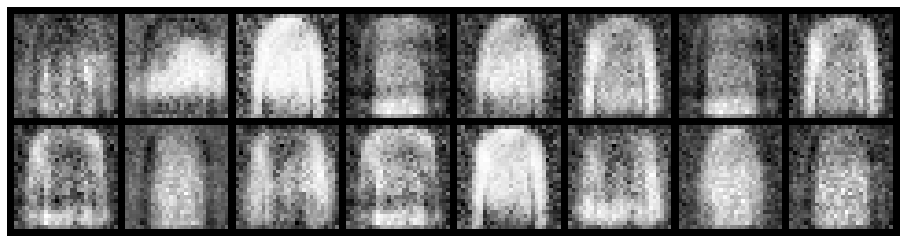

Epoch: [6/200], Batch Num: [0/938]
Discriminator Loss: 0.9631, Generator Loss: 1.4944
D(x): 0.6738, D(G(z)): 0.2751


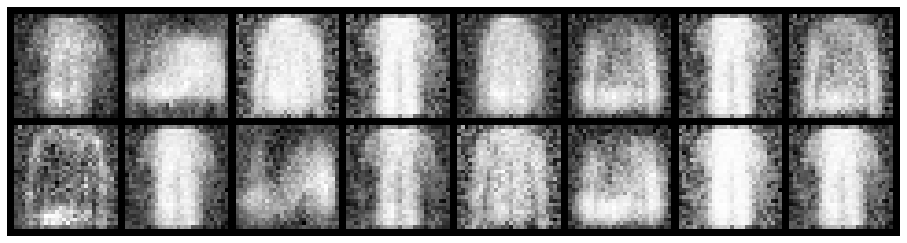

Epoch: [6/200], Batch Num: [100/938]
Discriminator Loss: 0.9296, Generator Loss: 1.5931
D(x): 0.6792, D(G(z)): 0.2837


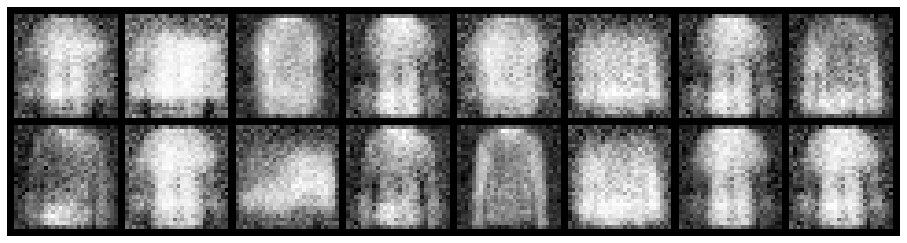

Epoch: [6/200], Batch Num: [200/938]
Discriminator Loss: 0.9500, Generator Loss: 1.3775
D(x): 0.6994, D(G(z)): 0.3420


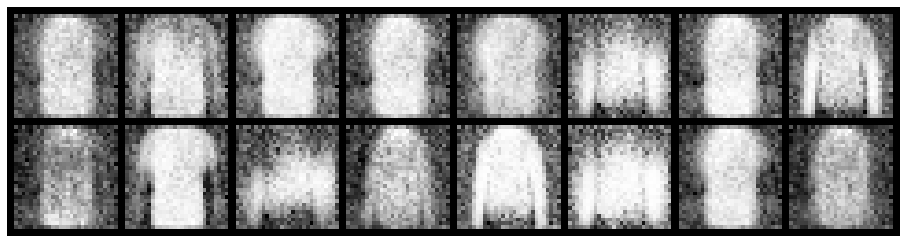

Epoch: [6/200], Batch Num: [300/938]
Discriminator Loss: 1.0986, Generator Loss: 1.2612
D(x): 0.6197, D(G(z)): 0.2961


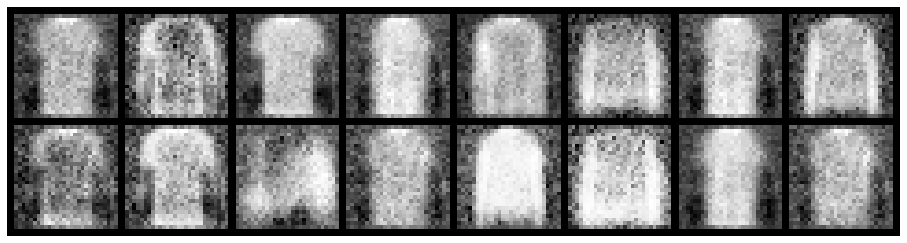

Epoch: [6/200], Batch Num: [400/938]
Discriminator Loss: 1.0946, Generator Loss: 1.4004
D(x): 0.5878, D(G(z)): 0.2855


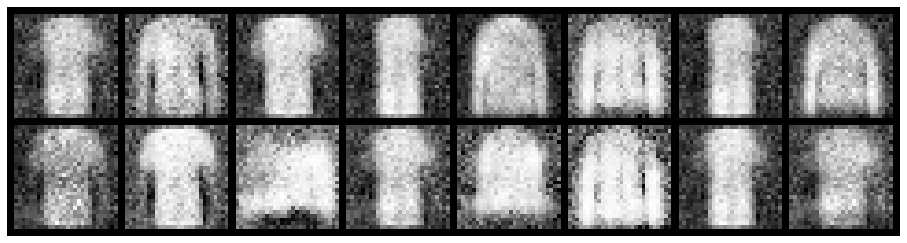

Epoch: [6/200], Batch Num: [500/938]
Discriminator Loss: 0.7203, Generator Loss: 1.8566
D(x): 0.7341, D(G(z)): 0.2386


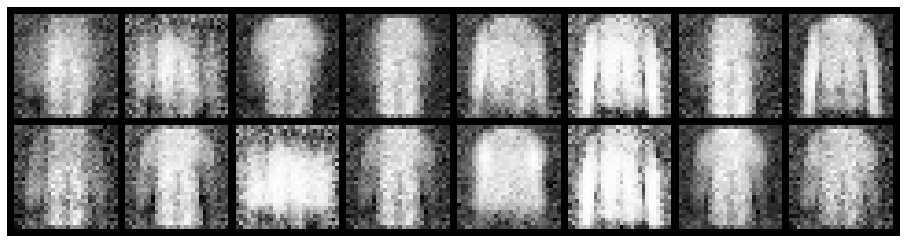

Epoch: [6/200], Batch Num: [600/938]
Discriminator Loss: 0.9422, Generator Loss: 1.4746
D(x): 0.7452, D(G(z)): 0.3196


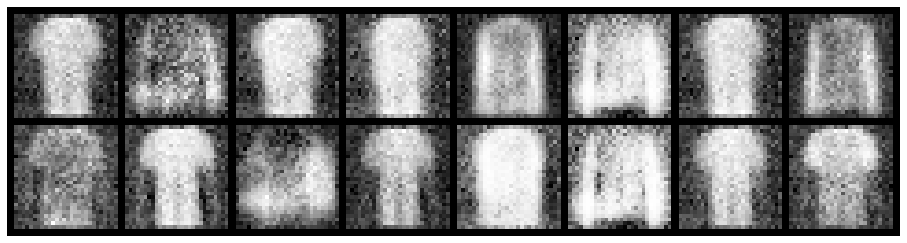

Epoch: [6/200], Batch Num: [700/938]
Discriminator Loss: 1.0485, Generator Loss: 1.0939
D(x): 0.6820, D(G(z)): 0.3675


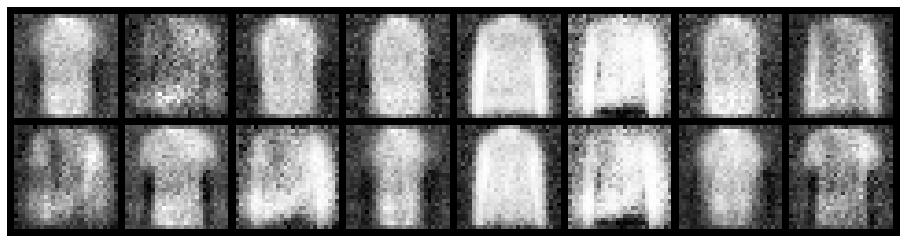

Epoch: [6/200], Batch Num: [800/938]
Discriminator Loss: 0.8609, Generator Loss: 1.4458
D(x): 0.7016, D(G(z)): 0.2697


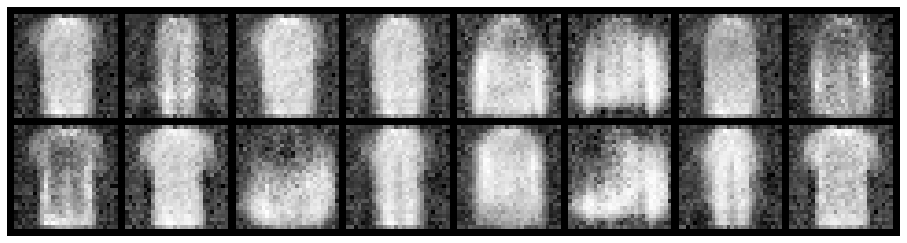

Epoch: [6/200], Batch Num: [900/938]
Discriminator Loss: 0.9383, Generator Loss: 1.2755
D(x): 0.6712, D(G(z)): 0.3388


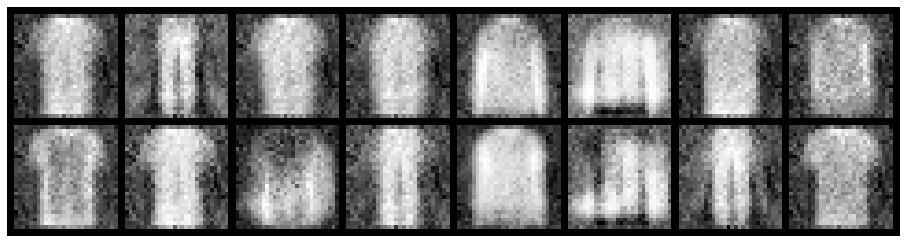

Epoch: [7/200], Batch Num: [0/938]
Discriminator Loss: 0.9839, Generator Loss: 1.4858
D(x): 0.6462, D(G(z)): 0.3032


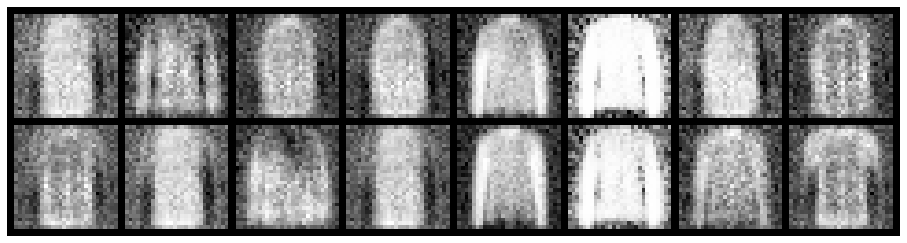

Epoch: [7/200], Batch Num: [100/938]
Discriminator Loss: 0.8728, Generator Loss: 1.0968
D(x): 0.7441, D(G(z)): 0.3590


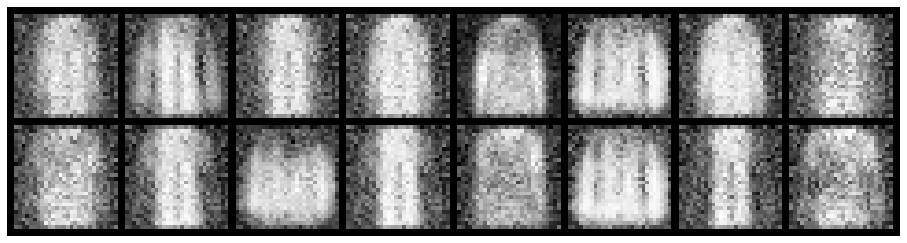

Epoch: [7/200], Batch Num: [200/938]
Discriminator Loss: 0.7386, Generator Loss: 1.4596
D(x): 0.7736, D(G(z)): 0.3110


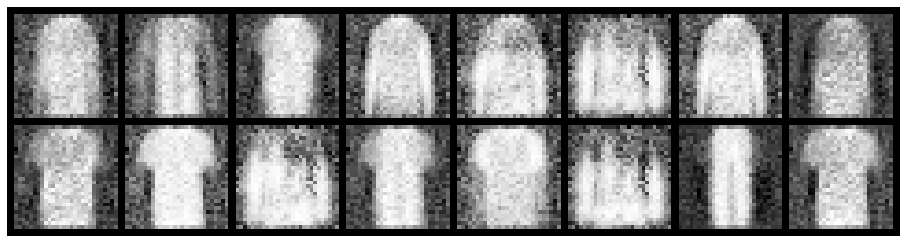

Epoch: [7/200], Batch Num: [300/938]
Discriminator Loss: 1.3194, Generator Loss: 1.5005
D(x): 0.5579, D(G(z)): 0.3234


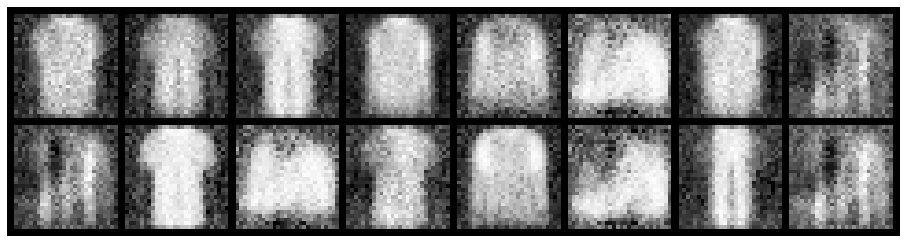

Epoch: [7/200], Batch Num: [400/938]
Discriminator Loss: 0.9803, Generator Loss: 1.3175
D(x): 0.6331, D(G(z)): 0.2942


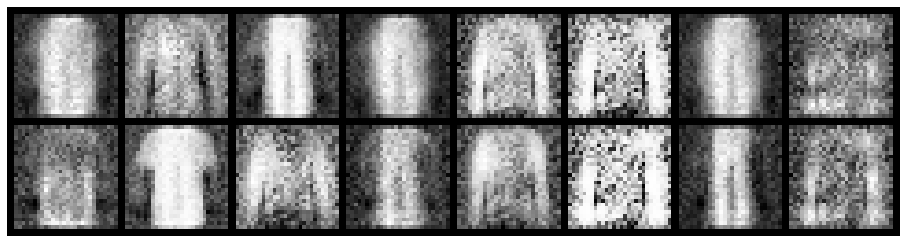

Epoch: [7/200], Batch Num: [500/938]
Discriminator Loss: 0.9919, Generator Loss: 1.4473
D(x): 0.6797, D(G(z)): 0.3422


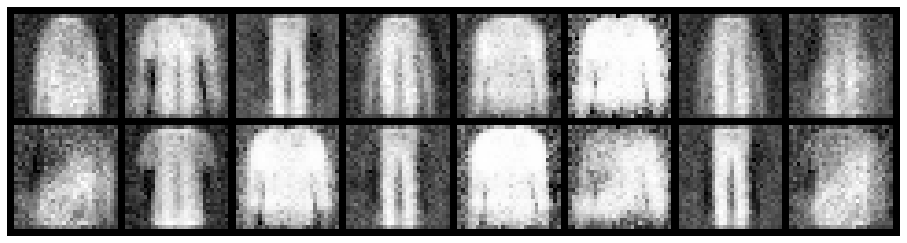

Epoch: [7/200], Batch Num: [600/938]
Discriminator Loss: 1.3030, Generator Loss: 1.0589
D(x): 0.5738, D(G(z)): 0.3981


In [ ]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200 
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()        
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator        
        # Generate fake data
        fake_data = generator(noise(N))       
        # Train G
        g_error = train_generator(g_optimizer, fake_data)     
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data            
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )